In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)

In [2]:
set.seed(1)

In [3]:
# valid columns when high speed
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'PathType') # 0.381
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeToCollision', 'RiskFactor', 'TimeHeadway') # 0.396
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeToCollision') # 0.382

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.024)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {            
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [6]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [7]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [8]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Red

In [9]:
df3 <- read.csv("../data/middle/sp2-5.csv", stringsAsFactors=FALSE)

In [18]:
colnames(df3)

[1] "Time"              "Longitude"         "Latitude"         
 [4] "Speed"             "Brake"             "Accel"            
 [7] "Engine"            "AheadDistance"     "Curve150"         
[10] "Curve100"          "Curve"             "SteeringAngle"    
[13] "BranchFlag"        "DistTollgate"      "RoadType"         
[16] "GreenLamp"         "RedLamp"           "RightLamp"        
[19] "UpLamp"            "LeftLamp"          "StopSign"         
[22] "Limit30Sign"       "Limit50Sign"       "BrakeCar"         
[25] "LeftCar"           "ManBicycleCount"   "ManBicycle"       
[28] "DistManBicycle"    "Pitch"             "DistSignal"       
[31] "PathType"          "LaneCount"         "AccelerationSpeed"
[34] "Jerk"              "AverageVelocity"   "MaxSpeed"         
[37] "MinSpeed"          "CurveAverage"      "flag"

In [10]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [11]:
allFeatures <- c(colnames(df3))
expr <- createFormula(invalids, allFeatures)

In [21]:
result <- CV(df3, expr, verbose=TRUE)
printRedRatios(df3)
printf("Red: Mean correct/predict = %f\n", result[2])
printf("Blue: Mean correct/predict = %f\n", result[3])
printf("CV value: %f", result[1])

Fold1
As for Red: correct/predict = 43/66 = 0.651515
As for Blue: correct/predict = 21/37 = 0.567568

Fold2
As for Red: correct/predict = 49/75 = 0.653333
As for Blue: correct/predict = 19/29 = 0.655172

Fold3
As for Red: correct/predict = 48/72 = 0.666667
As for Blue: correct/predict = 21/32 = 0.656250

Fold4
As for Red: correct/predict = 39/61 = 0.639344
As for Blue: correct/predict = 23/43 = 0.534884

Fold5
As for Red: correct/predict = 48/80 = 0.600000
As for Blue: correct/predict = 13/24 = 0.541667

Fold6
As for Red: correct/predict = 46/78 = 0.589744
As for Blue: correct/predict = 13/27 = 0.481481

Fold7
As for Red: correct/predict = 50/79 = 0.632911
As for Blue: correct/predict = 16/25 = 0.640000

Fold8
As for Red: correct/predict = 45/70 = 0.642857
As for Blue: correct/predict = 20/34 = 0.588235

Fold9
As for Red: correct/predict = 51/79 = 0.645570
As for Blue: correct/predict = 17/26 = 0.653846

Fold10
As for Red: correct/predict = 46/77 = 0.597403
As for Blue: correct/predict

In [13]:
fit3 <- rpart(expr, data=df3, method="class")

In [14]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.01410542

In [15]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
 [1] AccelerationSpeed AheadDistance     AverageVelocity   CurveAverage     
 [5] DistSignal        Engine            MaxSpeed          Pitch            
 [9] Speed             SteeringAngle    

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.077951      0   1.00000 1.00000 0.035602
2 0.014105      2   0.84410 0.89755 0.035012
3 0.013363      5   0.80178 0.96214 0.035418
4 0.012249      7   0.77506 0.95100 0.035357
5 0.011878      9   0.75056 0.95100 0.035357
6 0.011136     16   0.65924 0.95100 0.035357
7 0.010022     19   0.62584 0.94209 0.035305
8 0.010000     22   0.58797 0.93541 0.035265


In [16]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

          CP nsplit rel error    xerror       xstd
1 0.07795100      0 1.0000000 1.0000000 0.03560167
2 0.01410542      2 0.8440980 0.8975501 0.03501247
3 0.01336303      5 0.8017817 0.9621381 0.03541821
4 0.01224944      7 0.7750557 0.9510022 0.03535667
5 0.01187825      9 0.7505568 0.9510022 0.03535667
6 0.01113586     16 0.6592428 0.9510022 0.03535667
7 0.01002227     19 0.6258352 0.9420935 0.03530493
8 0.01000000     22 0.5879733 0.9354120 0.03526465

Variable importance
       DistSignal             Speed   AverageVelocity          MaxSpeed 
               15                14                11                10 
            Pitch     AheadDistance AccelerationSpeed          RoadType 
                8                 7                 7                 6 
           Engine             Curve      CurveAverage          MinSpeed 
                6                 5                 4                 3 
    Steering

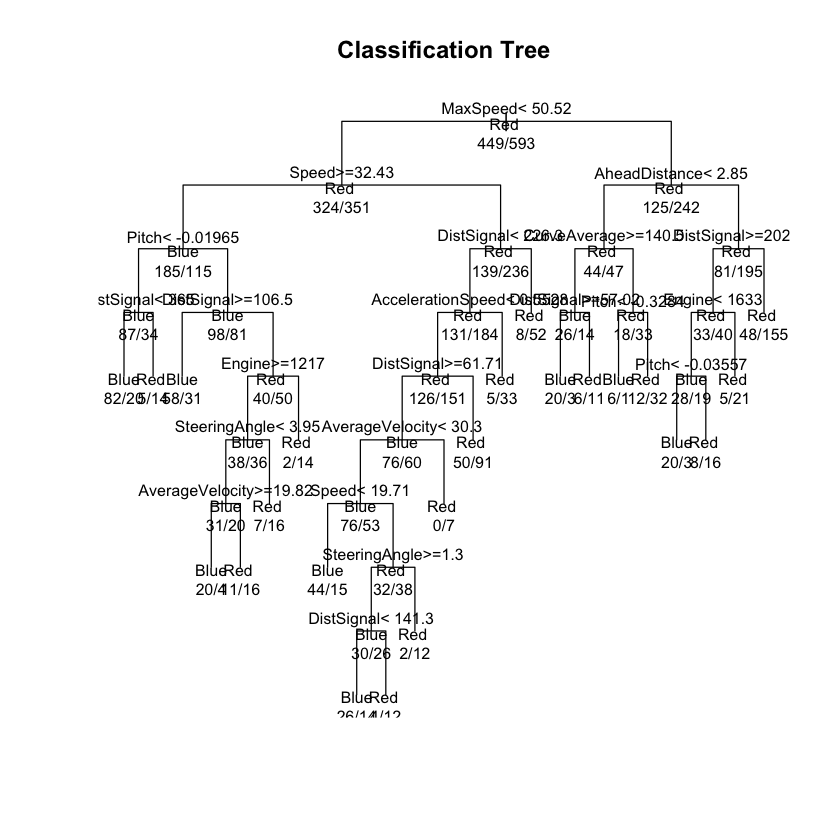

In [17]:
plot(fit3, uniform=TRUE, main="Classification Tree")
text(fit3, use.n=TRUE, all=TRUE, cex=.8)